# Simulating DESI Spectra

The goal of this notebook is to demonstrate how to generate some simple DESI spectra using the *quickgen* utility.  For simplicity we will only generate 1D spectra and skip the more computationally intensive (yet still instructive!) step of extracting 1D spectra from simulated 2D spectra (i.e., so-called "pixel-level simulations").

For additional (albeit somewhat outdated) information and documentation about *quickgen* see  
https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=1429

If you identify any errors or have requests for additional functionality please create a new issue on  
https://github.com/desihub/desisim/issues
or send a note to <desi-data@desi.lbl.gov>.

## Getting started.

First, import all the package dependencies.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import makebricks

from desiutil.log import get_logger
log = get_logger()

Make sure we have all the right environment variables set (assuming the bash shell).  If any of these environment variables are missing please set them in your *.bashrc* file (and then restart this notebook) or create them for just this notebook session using the *%set_env* magic command, as we demonstrate below.

In [4]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [5]:
check_env()

DESIMODEL environment set to /Users/sbailey/desi/git/desimodel/svn/trunk
DESI_ROOT environment set to /data/desi
DESI_SPECTRO_SIM environment set to /data/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /data/desi/spectro/data
DESI_SPECTRO_REDUX environment set to /data/desi/spectro/redux
SPECPROD environment set to debug
PIXPROD environment set to debug


Let's reassign the *\$SPECPROD* environment to something other than "dailytest" so that we don't conflict with the outputs of the standard DESI integration test.  In addition, we need to make raw data input *\$DESI_SPECTO_DATA* match *\$DESI_SPECTRO_SIM/\$PIXPROD* where the simulated data will be written.

In [6]:
%set_env SPECPROD=example
%set_env PIXPROD=example
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to '+desisim.io.simdir())
print('Pipeline will read raw data from '+desispec.io.rawdata_root())
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to '+desispec.io.specprod_root())

env: SPECPROD=example
env: PIXPROD=example
env: DESI_SPECTRO_DATA=/data/desi/spectro/sim/example/
Simulated raw data will be written to /data/desi/spectro/sim/example/
Pipeline will read raw data from /data/desi/spectro/sim/example/
    (without knowing that it was simulated)
Pipeline will write processed data to /data/desi/spectro/redux/example


## Specify the parameters of the simulation.

Next, specify the number and spectral type distribution of spectra we want to simulate, and the random seed.  Setting the seed here (which can be any number at all!) ensures that your simulations are reproducible.  Let's also explicitly set the *night* of the "observations" (the default is to use the current date) and the *expid* or exposure ID number (which would allow you to simulate more than one DESI exposure).

The *flavor* option is used to choose the correct sky-brightness model and it also determines the distribution of targets for a given flavor.  For example, *flavor='dark'* returns the right relative sampling density of ELGs, LRGs, and QSOs.  The other available (science target) options for *flavor* are 'dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', and 'std'.  (You can also set flavor to either 'arc' or 'flat' but that would be boring!)

In [7]:
nspec = 50
seed = 555
flavor = 'dark'
night = '20170615'
expid = 0

In [8]:
simdir = desisim.io.simdir(night=night)
print(simdir)

/data/desi/spectro/sim/example/20170615


## Generate the fibermap and truth tables.

The first step is to generate the *fibermap* and *simspec* files needed by *quickgen*.  The *fibermap* table contains (simulated) information about the position of each target in the DESI focal plane, while the *simspec* table holds the "truth" spectra and the intrinsic properties of each object (redshift, noiseless photometry, [OII] flux, etc.).

Note that the *tileid* and *exptime* (exposure time) optional inputs are shown here for demonstration purposes but do not need to be explicitly set.  In particular, the default exposure time is based on the value specified in the *$DESIMODEL/data/desi.yaml* parameter file.

The *fibermap* object is an astropy Table with lots of goodies while the *truth* object is a dictionary that we won't use anymore (we'll instead use the *simspec* table; see below).  The fibermap data model is described at  
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_DATA/NIGHT/fibermap-EXPID.html

In [9]:
fibermap, truth = new_exposure(flavor=flavor, nspec=nspec, seed=seed, night=night, 
                               expid=expid, tileid=None, exptime=None)

INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits
INFO:io.py:625:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits
INFO:obs.py:226:new_exposure: skyfile /Users/sbailey/desi/git/desimodel/svn/trunk/data/spectra/spec-sky.dat
INFO:obs.py:297:new_exposure: Wrote /data/desi/spectro/s

Let's see what got written to the raw data directory as a result of that last command:

In [10]:
rawdata_dir = desispec.io.rawdata_root()
!find $rawdata_dir | sort

/data/desi/spectro/sim/example/
/data/desi/spectro/sim/example//20170615
/data/desi/spectro/sim/example//20170615/fibermap-00000000.fits
/data/desi/spectro/sim/example//20170615/simspec-00000000.fits
/data/desi/spectro/sim/example//etc
/data/desi/spectro/sim/example//etc/obslog.sqlite


## Generating your own spectra ##

`new_exposure` is a convenience function for generating random typical exposures of various types for testing, but it isn't intended for every possible analysis.  If you want to use your own mix of objects, you just need to write your own fibermap and simspec files following that format instead of calling `new_exposure`.

The *simspec* and *fibermap* data models are described at  
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_SIM/PIXPROD/NIGHT/simspec-EXPID.html
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_DATA/NIGHT/fibermap-EXPID.html

**TODO**: update the datamodel documentation to match what is actually written!

**NOTE**: the simspec file format may change in the near future, so structure your code to separate generating spectra from the code for writing these particular formats.

Finally, even though we have the *fibermap* table in hand, the code below demonstrates how it and the *simspec* table can be read from on-disk.  In particular, the simspec METADATA HDU contains an extensive (and useful!) metadata table.

In general code should not generate filepaths by hand, but rather call `desispec.io.findfile` to find the file it needs.  If you
need to override the standard environment variable locations, you can use the `outdir` option,
while still letting it construct the canonical filename for each type of file.



In [11]:
fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

In [12]:
log.info('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
hdu.info()
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()

INFO:<ipython-input-12-55ef607f5bdd>:1:<module>: Reading fibermap file /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
Filename: /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   ()              
1    FIBERMAP    BinTableHDU     98   50R x 26C    [10A, 20A, 8A, K, K, K, K, 5E, 50A, J, J, J, J, J, J, E, D, D, D, D, D, D, D, D, E, E]   


In [13]:
fibermap[3]

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
str10,str20,str8,int64,int64,int64,int64,float32,str10,int32,int32,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
SKY,,3350p205,4183104322407110374,4294967296,0,0,0.0 .. 0.0,..,0,82,82,82,0,3,5400.0,335.167583443,20.5840708185,335.167583443,20.5840708185,-31.5795923296,-172.635369698,-31.5795923296,-172.635369698,0.0,0.0


In [14]:
log.info('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
hdu.info()
meta = Table(hdu['METADATA'].data)
hdu.close()

INFO:<ipython-input-14-f05bf983fedc>:1:<module>: Reading simspec file /data/desi/spectro/sim/example/20170615/simspec-00000000.fits.
Filename: /data/desi/spectro/sim/example/20170615/simspec-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      15   ()              
1    WAVE        ImageHDU         9   (31901,)     float64   
2    FLUX        ImageHDU         9   (31901, 50)   float32   
3    SKYFLUX     ImageHDU         8   (31901,)     float32   
4    WAVE_B      ImageHDU         9   (12326,)     float64   
5    PHOT_B      ImageHDU         8   (12326, 50)   float32   
6    SKYPHOT_B   ImageHDU         7   (12326,)     float32   
7    WAVE_R      ImageHDU         9   (11205,)     float64   
8    PHOT_R      ImageHDU         8   (11205, 50)   float32   
9    SKYPHOT_R   ImageHDU         7   (11205,)     float32   
10   WAVE_Z      ImageHDU         9   (12765,)     float64   
11   PHOT_Z      ImageHDU         8   (12765, 50)   float32

In [15]:
meta[:3]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,DECAM_FLUX [6],WISE_FLUX [2],OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ELG,,3512,3244113739,1.25838,22.937,0.441517 .. 1.32143,2.19795 .. 1.99019,8.25246e-17,-1.0,73.3845,-1.0,1.00652,68.2661,0.733237,-0.0850786,0.275525,-0.248196,-0.19466,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,4951,3952505139,0.820804,22.6349,0.616534 .. 1.59198,2.13285 .. 1.34848,4.69683e-17,-1.0,25.1577,-1.0,1.03366,40.1724,0.757255,-0.00885063,0.630011,-0.265495,-0.230491,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,6928,369720621,1.11619,21.8746,1.64478 .. 2.487,2.91573 .. 2.2421,1.45983e-16,-1.0,48.7059,-1.0,0.990213,40.1724,0.698619,-0.00354248,0.468131,-0.177077,-0.244851,-1.0,-1.0,-1.0,-1.0,-1.0


Here's a fun simple plot of the redshift histogram distributions.  Now you try!

(-0.2, 1.6220408082008364)

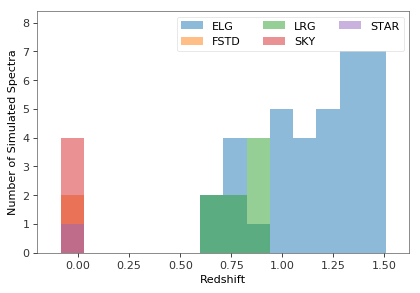

In [16]:
allobjtype = meta['OBJTYPE']
redlim = (-0.2, 1.1*meta['REDSHIFT'].max())
fig, ax = plt.subplots()
for objtype in sorted(set(allobjtype)):
    indx = objtype == allobjtype
    hh = ax.hist(meta['REDSHIFT'][indx], bins=nspec//3, 
                 label=objtype, alpha=0.5, range=redlim)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Simulated Spectra')
ax.legend(loc='upper right', ncol=3)
ax.margins(0.2)
ax.set_xlim(redlim)

## Setting up a production directory ##

Before proceeding with simulating noisy output spectra, we will call `desi_pipe`
to setup a production directory hierarchy.  We'll tell it to skip several
of the initial steps since we will use `quickgen` to directly simulate
extracted and calibrated spectra instead of generating pixel-level raw data.

The following code is equivalent to calling the command line
```
desi_pipe --fakeboot --fakepsf --fakepix
```

In [17]:
from desispec.scripts import pipe_prod
args = pipe_prod.parse(['--fakeboot', '--fakepsf', '--fakepix'])
pipe_prod.main(args)

Working with production /data/desi/spectro/redux/example :
  Updating plans ...


/Users/sbailey/anaconda/envs/desi/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


KeyError: 'r0'

In [18]:
#- What went wrong?  Check environments and files
for var in ['DESI_SPECTRO_DATA', 'DESI_SPECTRO_REDUX', 'SPECPROD']:
    print('{}={}'.format(var, os.getenv(var)))

rawdir = os.path.join(os.getenv('DESI_SPECTRO_DATA'))
!find $rawdir | sort

DESI_SPECTRO_DATA=/data/desi/spectro/sim/example/
DESI_SPECTRO_REDUX=/data/desi/spectro/redux
SPECPROD=example
/data/desi/spectro/sim/example/
/data/desi/spectro/sim/example//20170615
/data/desi/spectro/sim/example//20170615/fibermap-00000000.fits
/data/desi/spectro/sim/example//20170615/simspec-00000000.fits
/data/desi/spectro/sim/example//etc
/data/desi/spectro/sim/example//etc/obslog.sqlite


## Simulating spectra using quickgen.

We're now ready to simulate DESI spectra using *quickgen*!  Since we're calling *quickgen* from within this notebook (rather than from the command line in a terminal) we have to parse the *simspec* and *fibermap* filename inputs first.

*quickgen* generates four types of files and writes them to the *\$DESI_SPECTRO_REDUX/\$SPECPROD/exposures* directory: *calib*, *sky*, *cframe*, and *frame* files.  We will use the *cframe*, or calibrated frame files, which contain the flux-calibrated and sky-subtracted DESI spectra.  The data model and the other files and their contents are documented here:  
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/PRODNAME/exposures/NIGHT/EXPID/index.html

The following code calls the equivalent of the command line:
```
quickgen --simspec {simspecfile} --fibermap {fiberfile}
```

In [19]:
args = quickgen.parse([
    '--simspec', simspecfile,
    '--fibermap', fiberfile
])
quickgen.main(args)

INFO:quickgen.py:242:main: Reading fibermap file /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
INFO:quickgen.py:275:main: Initializing SpecSim with config desi
INFO:quickgen.py:281:main: Reading input file /data/desi/spectro/sim/example/20170615/simspec-00000000.fits
INFO:quickgen.py:310:main: Only 50 spectra in input file
INFO:quickgen.py:672:main: Writing files for channel:b, spectrograph:0, spectra:0 to 50
INFO:quickgen.py:699:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-b0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-b0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/sky-b0-00000000.fits
INFO:quickgen.py:753:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/calib-b0-00000000.fits
INFO:quickgen.py:672:main: Writing files for channel:r, spectrograph:0, spectra:0 t

INFO:quickgen.py:699:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-r0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-r0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/sky-r0-00000000.fits
INFO:quickgen.py:753:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/calib-r0-00000000.fits
INFO:quickgen.py:672:main: Writing files for channel:z, spectrograph:0, spectra:0 to 50
INFO:quickgen.py:699:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-z0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-z0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/sky-z0-00000000.fits
INFO:quickgen.py:753:main: Wrote file /data/desi/spectro/red

Next, let's combine and reorganize the individual *cframe* files into *spectra* files grouped on the sky.

**TODO**: Add the spectra files to the desidatamodel

**TODO**: Proceed with calling desi_group_spectra, but first we need to production generation above.